In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix

%matplotlib inline

In [3]:
data_path = 'data/creditcard.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
# Sampling the data as we have imbalanced data:

# we are reducing the size of the normal data to 50%, ie. we are undersampling 
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [8]:
print(f"Normal data shape: {normal.shape}")
print(f"Anomaly data shape: {anomaly.shape}")

Normal data shape: (142158, 31)
Anomaly data shape: (492, 31)


In [9]:
# splitting the data into train and test:

normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

In [10]:
# splitting the training set into train and validate:

normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [11]:
print(f"{normal_train.shape}, {normal_validate.shape}, {normal_test.shape}")
print(f"{anomaly_train.shape}, {anomaly_validate.shape}, {anomaly_test.shape}")

(85294, 31), (28432, 31), (28432, 31)
(294, 31), (99, 31), (99, 31)


In [14]:
# concatenating the train, validate and test sets:

X_train = pd.concat((normal_train, anomaly_train))
X_validate = pd.concat((normal_validate, anomaly_validate))
X_test = pd.concat((normal_test, anomaly_test))

In [15]:
# creating the dependent train, validate and test sets:

y_train = np.array(X_train['Class'])
y_validate = np.array(X_validate['Class'])
y_test = np.array(X_test['Class'])

In [16]:
# now dropping the 'Class' column from the X data set:

X_train = X_train.drop('Class', axis=1)
X_validate = X_validate.drop('Class', axis=1)
X_test = X_test.drop('Class', axis=1)

In [18]:
print(f"Training Shape:\n {X_train.shape}, {y_train.shape}")
print(f"Validation Shape:\n {X_validate.shape}, {y_validate.shape}")
print(f"Test Shape:\n {X_test.shape}, {y_test.shape}")

Training Shape:
 (85588, 30), (85588,)
Validation Shape:
 (28531, 30), (28531,)
Test Shape:
 (28531, 30), (28531,)


In [20]:
# Scaling the data:

scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop('Class', axis=1))

StandardScaler()

In [21]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validate = scaler.transform(X_validate)

In [23]:
# training logistic regression:
logreg = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(X_train, y_train)

In [25]:
# model evalluation
eval_acc = logreg.score(X_test, y_test)

preds = logreg.predict(X_test)
auc_score = roc_auc_score(y_test, preds)

In [28]:
print(f"Accuracy Score: {eval_acc:.3%}")
print(f"AUC Score: {auc_score:.3%}")

Accuracy Score: 99.867%
AUC Score: 84.331%


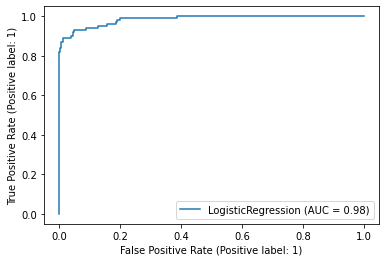

In [29]:
# Plotting the ROC curve:
roc_curve = plot_roc_curve(logreg, X_test, y_test)

In [30]:
# Looking at the confusion matrix:
conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)

[[28425     7]
 [   31    68]]


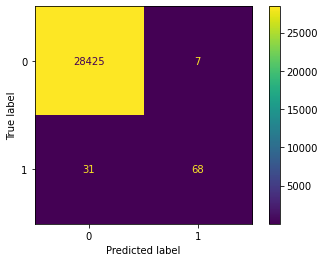

In [32]:
# plotting the confusion matrix
plot_confusion_matrix(logreg, X_test, y_test)

In [33]:
# Model Validation using kfold cross validation
anomaly_weights = [1, 5, 10, 15]
num_folds = 5

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [34]:
logs = []

for i in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(X_validate, y_validate):
        weight = anomaly_weights[i]
        class_weights = {
            0: 1,
            1: weight
        }
        
        model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg',
                                  class_weight=class_weights).fit(X_validate[train], y_validate[train])
        
        for h in range(40):
            print('-', end="")
        print(f"\nfold {fold}\nAnomaly Weight: {weight}")
        
        eval_acc = model.score(X_validate[test], y_validate[test])
        preds = model.predict(X_validate[test])
        
        try:
            auc_score = roc_auc_score(y_validate[test], preds)
        except:
            auc_score = -1
        
        print(f"AUC: {auc_score}\nEval Accuracy: {eval_acc}")
        
        accuracies.append(eval_acc)
        auc_scores.append(auc_score)
        
        log = [model, X_validate[test], y_validate[test], preds]
        logs.append(log)
        fold = fold + 1
    
    print("\nAverages: ")
    print(f"Accuracy: {np.mean(accuracies)}")
    print(f"AUC: {np.mean(auc_scores)}")
    
    print("Best:")
    print(f"Accuracy: {np.max(accuracies)}")
    print(f"AUC: {np.max(auc_scores)}")

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
Eval Accuracy: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
Eval Accuracy: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
Eval Accuracy: 0.9980722046968104
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
Eval Accuracy: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
Eval Accuracy: 0.9989484752891693

Averages: 
Accuracy: 0.9985629653623302
AUC: 0.8391790849957024
Best:
Accuracy: 0.9989484752891693
AUC: 0.8682452129973255
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
Eval Accuracy: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
Eval Accuracy: 0.9980722046968104
------------------------

###### Looking at the results we see that ANOMALY WEIGHT = 10, gives us the best result
- To be specific, the model with ANOMALY WEIGHT = 10 and the second fold is the best model.

In [35]:
model, X_val, y_val, preds = logs[11]

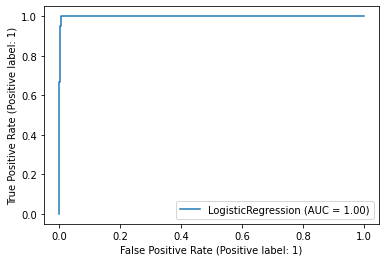

In [36]:
# lets look at the ROC plot of the above model:
roc_plot = plot_roc_curve(model, X_val, y_val)

In [38]:
print(roc_auc_score(y_val, preds))

0.9751350672194998


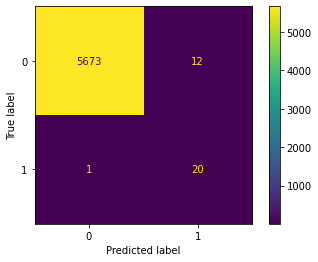

In [39]:
# Lets have a look at the confusion matrix to see why AUC score is 0.975:

plot_confusion_matrix(model, X_val, y_val)

In [42]:
# saving the model:
filename = 'models/logreg_sklearn.pkl'

pickle.dump(model, open(filename, 'wb'))